# Gnosis Safe

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shroomdk import ShroomDK
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PowerTransformer

In [166]:
#Setting up shroomDK powered by Flipside
my_address = '0x06ED7E490144D4b74BD1C9F33F69DA402603540E'
key = '74d495c5-4a92-4d2f-baf4-b0296d042dcb'
sdk = ShroomDK(key)

In [167]:
safe_addresses = pd.read_csv('Safe user allocations - reworked - Sheet1.csv')

def create_sql_list(df,col):
    df_new = ""
    inputs = list(df[col])
    i = 0
    for row in inputs:
        if i < len(inputs) - 1:
            df_new = df_new + "lower('" + row + "'),"
        else:
            df_new = df_new + "lower('" + row + "')"
        i += 1
    df_new = df_new + ""
    return df_new   

In [168]:
def get_contract_info(string):
    sql = f"""
    SELECT
    contract_address ,
    COUNT(tx_hash) as "# of txs",
    CURRENT_DATE - MIN(DATE(block_timestamp)) as "Days since First Created",
    CURRENT_DATE - MAX(DATE(block_timestamp)) as "Days since Last Used",
    MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as "Activity Span",
    COUNT(DISTINCT(origin_from_address)) as "Unique Addresses From",
    COUNT(DISTINCT(origin_to_address)) as "Unique Addresses To"
    FROM ethereum.core.fact_event_logs
    WHERE contract_address in ({string})
    GROUP BY contract_address
    """
    query_result_set = sdk.query(
    sql)

    contracts = pd.DataFrame(query_result_set.records)
    contracts
    return contracts


In [169]:
max_number =round(len(safe_addresses) / 1000)
i = 0
df = pd.DataFrame()
max_number = 5
while i < max_number:
    first= i*1000
    second= 1000 + i*1000
    if first % 10000 == 0:
        print (f"{i / max_number } % Complete")
    string =create_sql_list(safe_addresses[first:second],'safe_address')
    contracts = get_contract_info(string)
    df = pd.concat([df, contracts])
    i += 1
    

0.0 % Complete


In [170]:
df.columns

Index(['contract_address', '# of txs', 'days since first created',
       'days since last used', 'activity span', 'unique addresses from',
       'unique addresses to'],
      dtype='object')

In [171]:
df['Low txs'] = df["# of txs"].apply(lambda x: 1 if x < 5 else 0)
df['Short Activity'] = df["activity span"].apply(lambda x: 1 if x < 3 else 0)
df["Low From"] = df["unique addresses from"].apply(lambda x: 1 if x < 2 else 0)
df["Low To"] = df["unique addresses to"].apply(lambda x: 1 if x < 2 else 0)

<AxesSubplot:xlabel='# of txs', ylabel='Count'>

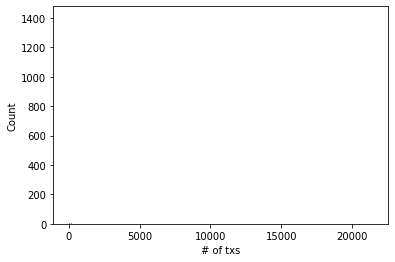

In [172]:
sns.histplot(x='# of txs',data = df)

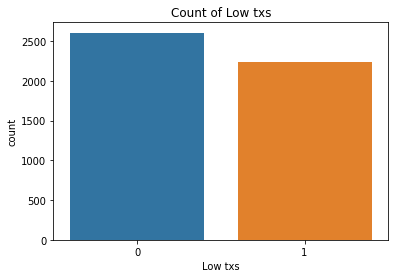

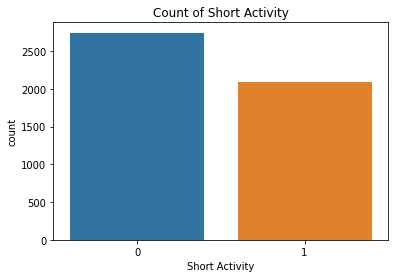

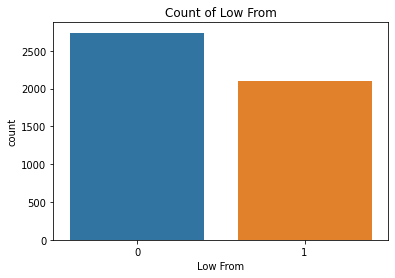

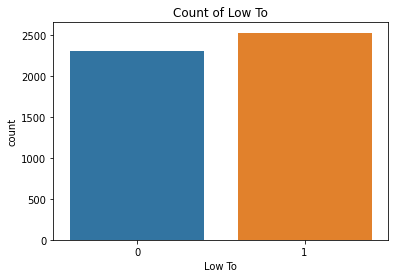

In [173]:
for col in ['Low txs','Short Activity','Low From','Low To'] :
    plt.figure()
    plt.title(f'Count of {col}')
    sns.countplot(x=col,data = df)

In [174]:
max_number =round(len(safe_addresses) / 1000)
i = 0
df = pd.DataFrame()
max_number = 5
while i < max_number:
    first= i*1000
    second= 1000 + i*1000
    if first % 10000 == 0:
        print (f"{i / max_number } % Complete")
    string =create_sql_list(safe_addresses[first:second],'safe_address')
    contracts = get_contract_info(string)
    df = pd.concat([df, contracts])
    i += 1

0.0 % Complete


In [175]:
a = "('0x0000000b71f2d236c38ae51952c46f03b89d0777','0x00004ee398ca93038d193dd34e89db467a298536','0x00008ca94c831a8d89eb701be216ea2f8c260004')"
# sql = f"""
# SELECT * 
# FROM ethereum.core.fact_event_logs
# WHERE EVENT_NAME = 'ExecutionSuccess'
# and contract_address IN {safe}
# LIMIT 20
# """
sql = f"""
--origin_from who created  it
--contract - safe address
WITH proxy_owners as (SELECT
block_timestamp,
tx_hash,
origin_from_address,
contract_address,
CONCAT('0x',substr(data,347,40)) AS Address1,
CONCAT('0x',substr(data,347+64,40)) AS Address2,
CONCAT('0x',substr(data,347+(64*2),40)) AS Address3,
CONCAT('0x',substr(data,347+(64*3),40)) AS Address4,
CONCAT('0x',substr(data,347+(64*4),40)) AS Address5,
CONCAT('0x',substr(data,347+(64*5),40)) AS Address6,
CONCAT('0x',substr(data,347+(64*6),40)) AS Address7,
CONCAT('0x',substr(data,347+(64*7),40)) AS Address8
FROM ethereum.core.fact_event_logs
LEFT JOIN (SELECT tx_hash as tx
FROM ethereum.core.fact_event_logs
WHERE EVENT_NAME = 'ProxyCreation' and CONTRACT_NAME = 'GnosisSafeProxyFactory'
) n ON tx = tx_hash
WHERE tx is NOT NULL
and  CONTRACT_NAME IS NULL
and origin_from_address = CONCAT('0x',substr(data,347,40))
and DATE(block_timestamp) < '2022-08-18'
)
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address1 as owner
FROM proxy_owners
WHERE Address1 != '0x'

UNION ALL

SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address2 as owner
FROM proxy_owners
WHERE Address2 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address3 as owner
FROM proxy_owners
WHERE Address3 != '0x'

UNION ALL

SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address4 as owner
FROM proxy_owners
WHERE Address4 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address5 as owner
FROM proxy_owners
WHERE Address5 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address6 as owner
FROM proxy_owners
WHERE Address6 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address7 as owner
FROM proxy_owners
WHERE Address7 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address8 as owner
FROM proxy_owners
WHERE Address8 != '0x'


"""

# Run the query against Flipside's query engine 
# and await the results
query_result_set = sdk.query(
sql)

owners_safe = pd.DataFrame(query_result_set.records)
owners_safe = owners_safe.drop_duplicates()

In [176]:
owners_safe = pd.merge(owners_safe,safe_addresses,left_on = 'safe_address', right_on = 'safe_address', how = 'left')
owners_safe = owners_safe[~owners_safe['tokens'].isna()]
owners_safe = pd.merge(owners_safe,df,left_on='safe_address', right_on='contract_address',how = 'left')


In [177]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,unique addresses from,unique addresses to
0,2022-07-06 06:44:53.000,0xf0f11560caa962341b25cf4f6cb1319fd57cd699cfa2...,0xcd37dcb108d6b992e40503634263f4022761a504,0x60c63bbb27f1f49f63eacadc773c79bf0c17ac7a,163.647286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-11 17:34:12.000,0xd3068c1264569003a83cabbddf8a53a6cd38e0532f24...,0xb01297956e383906f04b2a1c9503d548f847aa2a,0xdd664a5f8a94d5d8ebf765a9b628aeb39515dccc,633.536262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-07-04 11:26:49.000,0x5ba5229b48889f3f26c889390635e44f140ca4952627...,0xe591d606f700a92ac4635a87248fb47389290df6,0x8efdcdb249b464aeeec6b1dc43f30ce3ffd7d833,165.847154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-07-04 11:26:41.000,0x9b921b61463d961c5fa6c883a8774fb6314317f8200d...,0x233f07e6236a4baf06076774d83fb3b0fc4eeaa4,0xf3a338df40e26b83df1344bb77fcaece41d5c710,258.160693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-04 11:06:04.000,0x78513df65820815ed86ec0e7352689866c170ec93311...,0x778213333c2ac9d27f2d475f4cf1ed3480a567c1,0x28eaa79895bf16b5792a4f34eda977e1714c454c,138.583758,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
51254,2022-01-27 21:43:25.000,0x2aed594887fa0f975304c15593faec220ad064aa66be...,0xb4c3882f85c1d4b345e730d1e60783fb2c8da4f7,0xd9cfbc19a0e185b21d13171e5d5b15a3ff1830d7,831.159253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51255,2022-03-22 00:08:35.000,0x5fa8b626fe935743af645795634174b8f354e6ed0189...,0x0d49edd40b35142570459c367a56e1979f2c4cb9,0xe7f7e84b0156e9f167aeb0994bdbe6a478f5be64,2658.494974,0x0d49edd40b35142570459c367a56e1979f2c4cb9,8.0,175.0,88.0,87.0,5.0,2.0
51256,2022-03-22 01:46:30.000,0x2bbe41e7cbb2bee8b43c242ebfc8091df153488a95d4...,0xe5df47c084c5c4afbe636f13ba4f9f7de5e13201,0x71fc52edc6dd904482dd7af828db834efe87920e,388.480261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51257,2022-03-07 08:17:44.000,0x6cd73fb801763a96368fdc2dd6a260c8806cd5157960...,0xe55e4b315b75eb42095112455127598025258a88,0xa5a7468f177d94212cd0fdc0886ee732155c47e9,982.823734,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
safe_address_agg = pd.DataFrame(owners_safe.groupby('safe_address')['owner'].nunique()).rename(columns={'owner': '# of Owners for Safe Address'})
wallet_agg = pd.DataFrame(owners_safe.groupby('owner')['safe_address'].nunique()).rename(columns={'safe_address':'# of Wallets Owner Has'})
owners_safe = pd.merge(owners_safe,wallet_agg, on = 'owner',how = 'left')
owners_safe = pd.merge(owners_safe,safe_address_agg, on = 'safe_address', how = 'left')
#owners_safe.groupby(['owner'])['tokens'].transform(lambda x : zscore(x,ddof=1)).rename(columns={'safe_address':'# of Wallets Owner Has'})

owners_safe['Owns More Than 4 Safes']  = owners_safe['# of Wallets Owner Has'].apply(lambda x: 1 if  x > 4 else 0 )

In [179]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,unique addresses from,unique addresses to,# of Wallets Owner Has,# of Owners for Safe Address,Owns More Than 4 Safes
0,2022-07-06 06:44:53.000,0xf0f11560caa962341b25cf4f6cb1319fd57cd699cfa2...,0xcd37dcb108d6b992e40503634263f4022761a504,0x60c63bbb27f1f49f63eacadc773c79bf0c17ac7a,163.647286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
1,2022-07-11 17:34:12.000,0xd3068c1264569003a83cabbddf8a53a6cd38e0532f24...,0xb01297956e383906f04b2a1c9503d548f847aa2a,0xdd664a5f8a94d5d8ebf765a9b628aeb39515dccc,633.536262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0
2,2022-07-04 11:26:49.000,0x5ba5229b48889f3f26c889390635e44f140ca4952627...,0xe591d606f700a92ac4635a87248fb47389290df6,0x8efdcdb249b464aeeec6b1dc43f30ce3ffd7d833,165.847154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,0
3,2022-07-04 11:26:41.000,0x9b921b61463d961c5fa6c883a8774fb6314317f8200d...,0x233f07e6236a4baf06076774d83fb3b0fc4eeaa4,0xf3a338df40e26b83df1344bb77fcaece41d5c710,258.160693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0
4,2022-07-04 11:06:04.000,0x78513df65820815ed86ec0e7352689866c170ec93311...,0x778213333c2ac9d27f2d475f4cf1ed3480a567c1,0x28eaa79895bf16b5792a4f34eda977e1714c454c,138.583758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51254,2022-01-27 21:43:25.000,0x2aed594887fa0f975304c15593faec220ad064aa66be...,0xb4c3882f85c1d4b345e730d1e60783fb2c8da4f7,0xd9cfbc19a0e185b21d13171e5d5b15a3ff1830d7,831.159253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,0
51255,2022-03-22 00:08:35.000,0x5fa8b626fe935743af645795634174b8f354e6ed0189...,0x0d49edd40b35142570459c367a56e1979f2c4cb9,0xe7f7e84b0156e9f167aeb0994bdbe6a478f5be64,2658.494974,0x0d49edd40b35142570459c367a56e1979f2c4cb9,8.0,175.0,88.0,87.0,5.0,2.0,12,5,1
51256,2022-03-22 01:46:30.000,0x2bbe41e7cbb2bee8b43c242ebfc8091df153488a95d4...,0xe5df47c084c5c4afbe636f13ba4f9f7de5e13201,0x71fc52edc6dd904482dd7af828db834efe87920e,388.480261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,5,1
51257,2022-03-07 08:17:44.000,0x6cd73fb801763a96368fdc2dd6a260c8806cd5157960...,0xe55e4b315b75eb42095112455127598025258a88,0xa5a7468f177d94212cd0fdc0886ee732155c47e9,982.823734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,0


<AxesSubplot:title={'center':'Owns More Than 4 Safes'}, xlabel='Owns More Than 4 Safes', ylabel='count'>

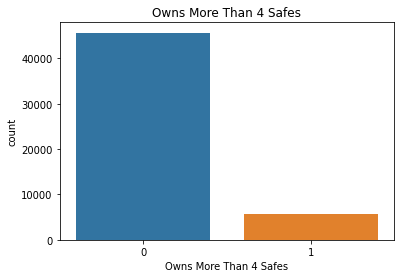

In [180]:
plt.figure()
plt.title(f'Owns More Than 4 Safes')
sns.countplot(x='Owns More Than 4 Safes',data = owners_safe)

<AxesSubplot:title={'center':'Distribution of Number of Safes Owner Has'}, xlabel='# of Wallets Owner Has', ylabel='Count'>

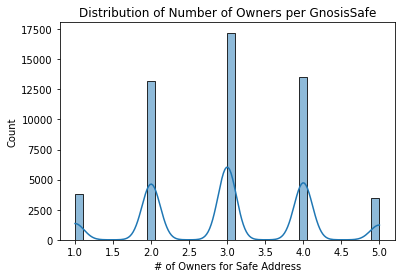

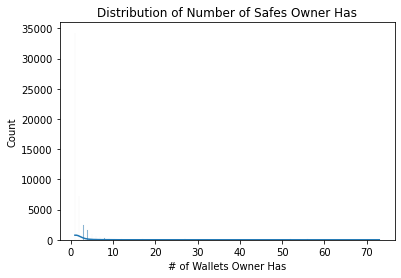

In [181]:
plt.figure()
plt.title('Distribution of Number of Owners per GnosisSafe')
sns.histplot(x='# of Owners for Safe Address',data=owners_safe, kde = True)

plt.figure()
plt.title('Distribution of Number of Safes Owner Has')
sns.histplot(x='# of Wallets Owner Has', data=owners_safe, kde = True)


In [182]:
def get_owner_info(string):
    sql = f"""
    WITH addy as (SELECT
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    WHERE origin_from_address in ({string})

    UNION ALL

    SELECT 
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    WHERE origin_from_address in ({string})
    )

    SELECT 
      address,
      CURRENT_DATE -  MIN(DATE(block_timestamp)) as days_since_first_tx,
      CURRENT_DATE -  MAX(DATE(block_timestamp)) as days_since_last_tx,
       MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as activity_span,
      COUNT(DISTINCT(tx_hash)) as no_owner_tx,
      COUNT(DISTINCT(contract_address)) as no_contracts,
      COUNT(DISTINCT(EVENT_NAME)) as no_events,
      COUNT(DISTINCT(interact)) as unique_addresses_interact
    FROM addy 
    GROUP BY address 
    """
    query_result_set = sdk.query(
        sql)

    owner = pd.DataFrame(query_result_set.records)
    return owner


In [183]:
#sns.histplot(data = owners_safe, x = )#


In [184]:
un = pd.DataFrame(owners_safe['owner'].drop_duplicates())

max_number =round(len(un) / 1000)
i = 0
own = pd.DataFrame()
max_number = 1
while i < max_number:
    first= i*1000
    second= 1000 + i*1000
    if first % 10000 == 0:
        print (f"{i / max_number } % Complete")
    string =create_sql_list(un[first:second],'owner')
    contracts = get_owner_info(string)
    own = pd.concat([own, contracts])
    print(i)
    i += 1
    

0.0 % Complete
0


In [185]:
own['Short Activity Own'] = own['activity_span'].apply(lambda x: 1 if x < 7 else 0)
own['Low Tx Own'] = own['no_owner_tx'].apply(lambda x: 1 if x < 10 else 0 )
own['Low Events'] = own['no_events'].apply(lambda x: 1 if x < 5 else 0)
own['Low Contract'] = own['no_contracts'].apply(lambda x: 1 if x < 5 else 0)
own['Low Addresses'] = own['unique_addresses_interact'].apply(lambda x: 1 if x < 5 else 0)

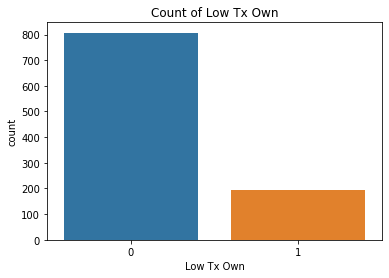

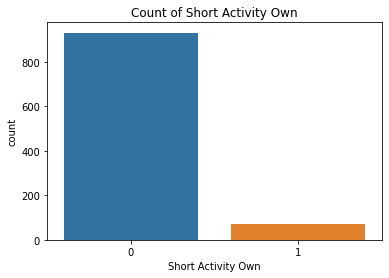

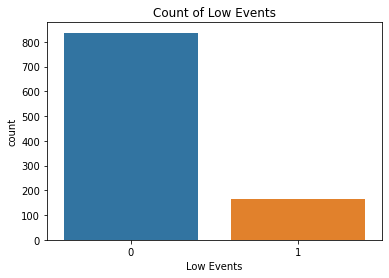

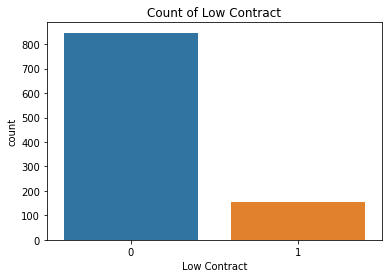

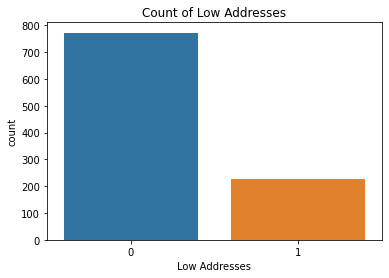

In [186]:
for col in ['Low Tx Own','Short Activity Own','Low Events','Low Contract', 'Low Addresses']:
    plt.figure()
    plt.title(f'Count of {col}')
    sns.countplot(x=col,data = own)

In [187]:
owners_safe = pd.merge(owners_safe,own,left_on = 'owner', right_on = 'address',how = 'left')

In [188]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,...,activity_span,no_owner_tx,no_contracts,no_events,unique_addresses_interact,Short Activity Own,Low Tx Own,Low Events,Low Contract,Low Addresses
0,2022-07-06 06:44:53.000,0xf0f11560caa962341b25cf4f6cb1319fd57cd699cfa2...,0xcd37dcb108d6b992e40503634263f4022761a504,0x60c63bbb27f1f49f63eacadc773c79bf0c17ac7a,163.647286,NaN,NaN,NaN,NaN,NaN,...,776.0,266.0,193.0,95.0,110.0,0.0,0.0,0.0,0.0,0.0
1,2022-07-11 17:34:12.000,0xd3068c1264569003a83cabbddf8a53a6cd38e0532f24...,0xb01297956e383906f04b2a1c9503d548f847aa2a,0xdd664a5f8a94d5d8ebf765a9b628aeb39515dccc,633.536262,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-07-04 11:26:49.000,0x5ba5229b48889f3f26c889390635e44f140ca4952627...,0xe591d606f700a92ac4635a87248fb47389290df6,0x8efdcdb249b464aeeec6b1dc43f30ce3ffd7d833,165.847154,NaN,NaN,NaN,NaN,NaN,...,68.0,34.0,45.0,33.0,27.0,0.0,0.0,0.0,0.0,0.0
3,2022-07-04 11:26:41.000,0x9b921b61463d961c5fa6c883a8774fb6314317f8200d...,0x233f07e6236a4baf06076774d83fb3b0fc4eeaa4,0xf3a338df40e26b83df1344bb77fcaece41d5c710,258.160693,NaN,NaN,NaN,NaN,NaN,...,108.0,55.0,42.0,20.0,22.0,0.0,0.0,0.0,0.0,0.0
4,2022-07-04 11:06:04.000,0x78513df65820815ed86ec0e7352689866c170ec93311...,0x778213333c2ac9d27f2d475f4cf1ed3480a567c1,0x28eaa79895bf16b5792a4f34eda977e1714c454c,138.583758,NaN,NaN,NaN,NaN,NaN,...,806.0,650.0,323.0,72.0,200.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51254,2022-01-27 21:43:25.000,0x2aed594887fa0f975304c15593faec220ad064aa66be...,0xb4c3882f85c1d4b345e730d1e60783fb2c8da4f7,0xd9cfbc19a0e185b21d13171e5d5b15a3ff1830d7,831.159253,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51255,2022-03-22 00:08:35.000,0x5fa8b626fe935743af645795634174b8f354e6ed0189...,0x0d49edd40b35142570459c367a56e1979f2c4cb9,0xe7f7e84b0156e9f167aeb0994bdbe6a478f5be64,2658.494974,0x0d49edd40b35142570459c367a56e1979f2c4cb9,8.0,175.0,88.0,87.0,...,469.0,47.0,22.0,7.0,15.0,0.0,0.0,0.0,0.0,0.0
51256,2022-03-22 01:46:30.000,0x2bbe41e7cbb2bee8b43c242ebfc8091df153488a95d4...,0xe5df47c084c5c4afbe636f13ba4f9f7de5e13201,0x71fc52edc6dd904482dd7af828db834efe87920e,388.480261,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51257,2022-03-07 08:17:44.000,0x6cd73fb801763a96368fdc2dd6a260c8806cd5157960...,0xe55e4b315b75eb42095112455127598025258a88,0xa5a7468f177d94212cd0fdc0886ee732155c47e9,982.823734,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
#Airdrop Info

token = ['LOOKs','HOP','ENS','SOS','1INCH','Ribbon',
         'AMP','X2Y2',
         #'PSP',
         'EULER','BEND','UNI','DYDX']

from_address = ['0xA35dce3e0E6ceb67a30b8D7f4aEe721C949B5970',
                '0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC',
                '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                #'0x5a5ecd062083733c9aa27cb4c5f113c42f730261',
                '0x0000000000000000000000000000000000000000',
                '0xe295ad71242373c37c5fda7b57f26f9ea1088afe',
                '0x7902e4bfb1eb9F4559d55417Aee1Dc6E4b8cC1Bf',
                '0xF497b83CfBd31E7Ba1Ab646F3B50aE0aF52d03A1',
                '0xe6949137b24ad50cce2cf6b124b3b874449a41fa',
                #'0xcAfE001067cDEF266AfB7Eb5A286dCFD277f3dE5',
                '0xd524e29e3baf5bb085403ca5665301e94387a7e2',
                '0x1b5d2904be3e4711a848be09b17dee89e6a5bc27',
                '0x090d4613473dee047c3f2706764f49e0821d256e',
                '0x639192d54431f8c816368d3fb4107bc168d0e871'
                
                
                ]
contract_address = ['0xf4d2888d29d722226fafa5d9b24f9164c092421e',
                   '0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC',
                   '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                   '0x3b484b82567a09e2588a13d54d032153f0c0aee0',
                   '0x111111111117dc0aa78b770fa6a738034120c302',
                   '0x6123b0049f904d730db3c36a31167d9d4121fa6b',
                    '0x77fba179c79de5b7653f68b5039af940ada60ce0',
                    '0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9',
                    #'0x090E53c44E8a9b6B1bcA800e881455b921AEC420',
                    '0xd9Fcd98c322942075A5C3860693e9f4f03AAE07b',
                    '0x0d02755a5700414b26ff040e1de35d337df56218',
                    '0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984',
                    '0x92D6C1e31e14520e676a687F0a93788B716BEff5'
                   ]
print(len(contract_address))
print(len(from_address))

df_airdrops = pd.DataFrame({
    'Token':token,
    'From Address':from_address,
    'Contract Address': contract_address
})

12
12


In [190]:
#functions query airdropers that have dumped a particular token in less than a week of a holding (wallet balence = 0)
def find_airdroppers(token,address,contract,owners_safe):
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as airdrop_recipient,
    contract_address as token
    FROM ethereum.core.fact_token_transfers
    WHERE contract_address = lower('{contract}')
    and from_address = lower('{address}')
    )

    SELECT --distinct(user_address)
    DATEDIFF(day, bt, block_timestamp) as "Time to Drop",
    user_address,
    prev_bal as amount_dumped
    FROM ethereum.core.ez_balance_deltas
    INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address
    WHERE current_bal = 0
    and DATEDIFF(day, bt, block_timestamp) < 14
    """

    query_result_set = sdk.query(
    sql)
    dumpers = pd.DataFrame(query_result_set.records)
    dumpers.columns = [str(col) + '_' + token if col != 'user_address' else col for col in dumpers.columns]
    no_dumpers = len(dumpers)
    print(f'Identifed {no_dumpers} that dumped {token} within a week')
    col_name = 'Dumped ' + token
    dumpers[col_name] = 1
    owners_safe = pd.merge(owners_safe,dumpers,left_on='owner',right_on='user_address',how='left')
    owners_safe = owners_safe.drop(columns=['user_address'])
    no_safes = owners_safe.loc[owners_safe[col_name] == 1,'safe_address'].unique()
    no_addresses = owners_safe.loc[owners_safe[col_name] == 1,'owner'].unique()
    owners_safe = owners_safe.fillna(0)
    owners_safe['Number of Airdrops Dumped'] = owners_safe['Number of Airdrops Dumped'] + owners_safe[col_name]
    #owners_safe['Tokens Dumped'] = owners_safe.apply(lambda x: x['Tokens Dumped'] +", "+ col_name if owners_safe[col_name] == 1 else x['Tokens Dumped'], axis = 1)
    owners_safe['Tokens Dumped'] = np.where(owners_safe[col_name] == 1, owners_safe['Tokens Dumped'] +", "+ col_name, owners_safe['Tokens Dumped'])
    print(f'Identifed {len(no_safes)} safes that had an owner dump {token}')
    print(f'Identifed {len(no_addresses)} owner addresses that dumped {token}')
    return owners_safe, no_dumpers, len(no_safes), len(no_addresses)
    

In [194]:
i = 0
dumped = []
safes = []
addresses = []
dumped_owners_safe = owners_safe[['owner','safe_address']].copy()
dumped_owners_safe['Number of Airdrops Dumped'] = 0
dumped_owners_safe['Tokens Dumped'] = ''
while i < len(df_airdrops):
    token = df_airdrops.loc[i,'Token']
    address = df_airdrops.loc[i,'From Address']
    contract = df_airdrops.loc[i,'Contract Address']
    dumped_owners_safe, no_dumpers, no_safes, no_addresses = find_airdroppers(token,address,contract,dumped_owners_safe)
    dumped.append(no_dumpers)
    safes.append(no_safes)
    addresses.append(no_addresses)
    i += 1
    


Identifed 34047 that dumped LOOKs within a week
Identifed 1043 safes that had an owner dump LOOKs
Identifed 838 owner addresses that dumped LOOKs
Identifed 2448 that dumped HOP within a week
Identifed 196 safes that had an owner dump HOP
Identifed 163 owner addresses that dumped HOP
Identifed 16777 that dumped ENS within a week
Identifed 852 safes that had an owner dump ENS
Identifed 692 owner addresses that dumped ENS
Identifed 50593 that dumped SOS within a week
Identifed 1369 safes that had an owner dump SOS
Identifed 1227 owner addresses that dumped SOS
Identifed 7888 that dumped 1INCH within a week
Identifed 131 safes that had an owner dump 1INCH
Identifed 100 owner addresses that dumped 1INCH
Identifed 26 that dumped Ribbon within a week
Identifed 0 safes that had an owner dump Ribbon
Identifed 0 owner addresses that dumped Ribbon
Identifed 7089 that dumped AMP within a week
Identifed 57 safes that had an owner dump AMP
Identifed 42 owner addresses that dumped AMP
Identifed 4905 

In [195]:
df_airdrops['# of Dumpers'] = dumped
df_airdrops['# of Safes'] = safes
df_airdrops['# of Addresses'] = addresses

<AxesSubplot:title={'center':'# of Gnosis Owners that Dumped by Token'}, xlabel='Token', ylabel='# of Addresses'>

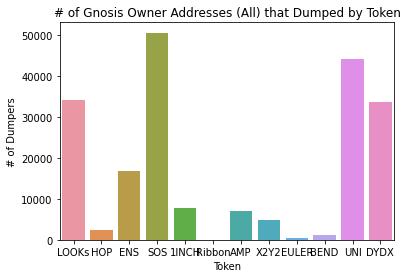

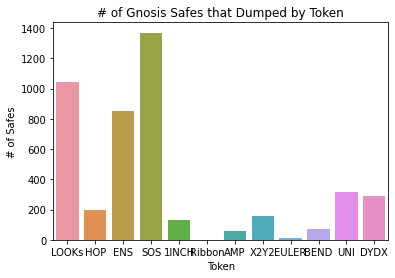

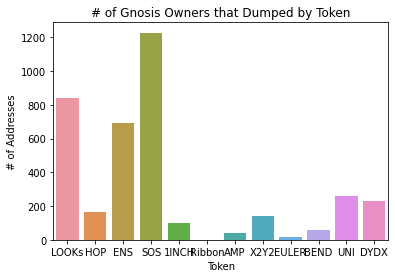

In [196]:
plt.figure()
plt.title('# of Gnosis Owner Addresses (All) that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Dumpers")
plt.figure()
plt.title('# of Gnosis Safes that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Safes")
plt.figure()
plt.title('# of Gnosis Owners that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Addresses")


In [197]:
#dumped_owners_safe[['safe_address','owner','Number of Airdrops Dumped','Tokens Dumped']].sort_values('Number of Airdrops Dumped',ascending = False)
#dumped_owners_safe = dumped_owners_safe.drop(columns = ['dumped_owners_safe','tx_hash'])
owners_safe = pd.merge(owners_safe, dumped_owners_safe,on = ['safe_address','owner'],how = 'left')

In [198]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,...,Dumped EULER,time to drop_BEND,amount_dumped_BEND,Dumped BEND,time to drop_UNI,amount_dumped_UNI,Dumped UNI,time to drop_DYDX,amount_dumped_DYDX,Dumped DYDX
0,2022-07-06 06:44:53.000,0xf0f11560caa962341b25cf4f6cb1319fd57cd699cfa2...,0xcd37dcb108d6b992e40503634263f4022761a504,0x60c63bbb27f1f49f63eacadc773c79bf0c17ac7a,163.647286,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
1,2022-07-11 17:34:12.000,0xd3068c1264569003a83cabbddf8a53a6cd38e0532f24...,0xb01297956e383906f04b2a1c9503d548f847aa2a,0xdd664a5f8a94d5d8ebf765a9b628aeb39515dccc,633.536262,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2,2022-07-04 11:26:49.000,0x5ba5229b48889f3f26c889390635e44f140ca4952627...,0xe591d606f700a92ac4635a87248fb47389290df6,0x8efdcdb249b464aeeec6b1dc43f30ce3ffd7d833,165.847154,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
3,2022-07-04 11:26:41.000,0x9b921b61463d961c5fa6c883a8774fb6314317f8200d...,0x233f07e6236a4baf06076774d83fb3b0fc4eeaa4,0xf3a338df40e26b83df1344bb77fcaece41d5c710,258.160693,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
4,2022-07-04 11:06:04.000,0x78513df65820815ed86ec0e7352689866c170ec93311...,0x778213333c2ac9d27f2d475f4cf1ed3480a567c1,0x28eaa79895bf16b5792a4f34eda977e1714c454c,138.583758,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,9.0,3.045700e-14,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52715,2022-01-27 21:43:25.000,0x2aed594887fa0f975304c15593faec220ad064aa66be...,0xb4c3882f85c1d4b345e730d1e60783fb2c8da4f7,0xd9cfbc19a0e185b21d13171e5d5b15a3ff1830d7,831.159253,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
52716,2022-03-22 00:08:35.000,0x5fa8b626fe935743af645795634174b8f354e6ed0189...,0x0d49edd40b35142570459c367a56e1979f2c4cb9,0xe7f7e84b0156e9f167aeb0994bdbe6a478f5be64,2658.494974,0x0d49edd40b35142570459c367a56e1979f2c4cb9,8.0,175.0,88.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
52717,2022-03-22 01:46:30.000,0x2bbe41e7cbb2bee8b43c242ebfc8091df153488a95d4...,0xe5df47c084c5c4afbe636f13ba4f9f7de5e13201,0x71fc52edc6dd904482dd7af828db834efe87920e,388.480261,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
52718,2022-03-07 08:17:44.000,0x6cd73fb801763a96368fdc2dd6a260c8806cd5157960...,0xe55e4b315b75eb42095112455127598025258a88,0xa5a7468f177d94212cd0fdc0886ee732155c47e9,982.823734,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0


In [203]:
# owners_safe['Tokens Dumped']

0                    
1                    
2                    
3                    
4        , Dumped UNI
             ...     
52715                
52716                
52717                
52718                
52719                
Name: Tokens Dumped, Length: 52720, dtype: object

<AxesSubplot:title={'center':'# of Safe Owners who have Dumped a Token'}, xlabel='Number of Airdrops Dumped', ylabel='Count'>

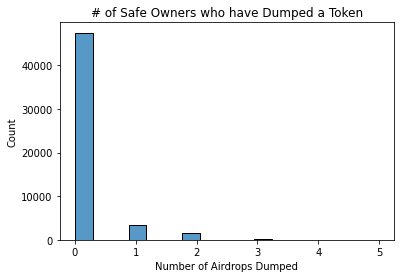

In [199]:
plt.figure("# of Users that Dumped")
plt.title('# of Safe Owners who have Dumped a Token')
sns.histplot(x = 'Number of Airdrops Dumped',data = dumped_owners_safe)

In [200]:
#Adding Potiential Flags


In [232]:
dc = [
'block_timestamp',
'tx_hash',
'contract_address',
'address',
'owner',
'Tokens Dumped',
'safe_address'
]

df_prep = owners_safe.copy()
df_prep = df_prep.drop(columns = dc)
df_prep = df_prep.fillna(0)
df_prep

,tokens,# of txs,days since first created,days since last used,activity span,unique addresses from,unique addresses to,# of Wallets Owner Has,# of Owners for Safe Address,Owns More Than 4 Safes,...,time to drop_BEND,amount_dumped_BEND,Dumped BEND,time to drop_UNI,amount_dumped_UNI,Dumped UNI,time to drop_DYDX,amount_dumped_DYDX,Dumped DYDX,Cluster
0,163.647286,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2
1,633.536262,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2
2,165.847154,0.0,0.0,0.0,0.0,0.0,0.0,1,4,0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2
3,258.160693,0.0,0.0,0.0,0.0,0.0,0.0,2,2,0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2
4,138.583758,0.0,0.0,0.0,0.0,0.0,0.0,2,2,0,...,0.0,0.0,0.0,9.0,3.045700e-14,1.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52715,831.159253,0.0,0.0,0.0,0.0,0.0,0.0,1,5,0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0
52716,2658.494974,8.0,175.0,88.0,87.0,5.0,2.0,12,5,1,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2
52717,388.480261,0.0,0.0,0.0,0.0,0.0,0.0,6,5,1,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0
52718,982.823734,0.0,0.0,0.0,0.0,0.0,0.0,2,5,0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0


In [233]:
for col in df_prep.columns:
  if type(df_prep[col].iloc[0]) is str:
    ohe = OneHotEncoder(sparse = False)
    encoded = pd.DataFrame(ohe.fit_transform(df_prep[col].values.reshape(-1,1)))
    encoded.columns = ohe.get_feature_names([col])
    df_prep = pd.concat([df_prep, pd.DataFrame(encoded)], axis = 1)
    df_prep = df_prep.drop(columns = [col])
  else:
    ss = StandardScaler()
    df_prep[col] = np.log10(df_prep[col] + 1e-7)
    df_prep[col] = df_prep[col].fillna(0)
    df_prep[col] = ss.fit_transform(df_prep[col].values.reshape(-1,1))

C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result 

In [234]:

# df_prep['Days Since First Sell'] = df_prep['Days Since First Sell'].astype(int)
# df_prep['Days Since Last Sell'] = df_prep['Days Since First Sell'].astype(int)


# df_prep = pd.DataFrame(scaled, index=df_prep.index, columns=df_prep.columns)
log_cols = ['# of txs',
            'no_owner_tx',
            'unique_addresses_interact',
            'no_contracts', 
            'unique addresses from']
scale_cols = [x for x in df_prep.columns if x not in log_cols]
scale_pipe = make_pipeline(StandardScaler())
log_pipe = make_pipeline(PowerTransformer())

transformer = ColumnTransformer(remainder='passthrough',
    transformers=[
        ("scale", scale_pipe, scale_cols),
        ("log_transform", log_pipe, log_cols),
    ]
)

df_prep = df_prep.reset_index(drop = True)
scaled = transformer.fit_transform(df_prep)  
df_prep.columns
df_prep = pd.DataFrame(scaled, index=df_prep.index, columns=df_prep.columns)


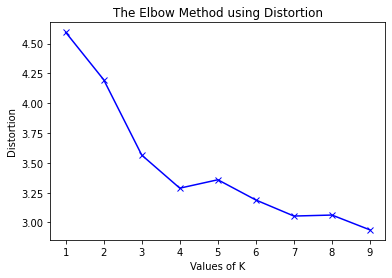

In [235]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
  
X = df_prep
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [236]:
km = KMeans(n_clusters=4)
km.fit(X)
label = km.labels_
owners_safe['Cluster'] = label

In [237]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df_prep)
res = pd.DataFrame(pca.transform(df_prep))


In [238]:
pca1 = abs(pca.components_[0])
pca2 = abs(pca.components_[1])
k = 10
pca1_index = np.argpartition(pca1, len(pca1) - k)[-k:]
pca2_index = np.argpartition(pca2, len(pca2) - k)[-k:]

In [239]:
pca1_most_important = df_prep.columns[pca1_index]
pca2_most_important = df_prep.columns[pca2_index]
print("Most Important Features for X: " + str(pca1_most_important))
print("Most Important Features for Y: " + str(pca2_most_important))

Most Important Features for X: Index(['no_contracts', 'unique_addresses_interact', 'amount_dumped_UNI',
       'Owns More Than 4 Safes', 'days_since_first_tx', 'days_since_last_tx',
       'time to drop_DYDX', 'amount_dumped_DYDX', 'Dumped DYDX',
       '# of Owners for Safe Address'],
      dtype='object')
Most Important Features for Y: Index(['time to drop_DYDX', 'activity span', 'days since first created',
       'days since last used', 'amount_dumped_UNI', 'Dumped DYDX',
       'amount_dumped_DYDX', 'Cluster', 'Dumped UNI', '# of txs'],
      dtype='object')


<AxesSubplot:title={'center':'Clustering of GnosisSage Addresses'}, xlabel='0', ylabel='1'>

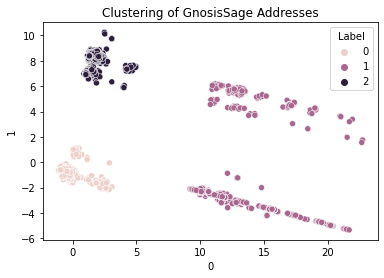

In [240]:
res['Label'] = label
plt.figure()
plt.title('Clustering of GnosisSage Addresses')
sns.scatterplot(x =0,y =1,hue ='Label',data = res)